# 04 - Clustering

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os
import matplotlib.animation as animation

from models.X_RCC import XRCC#, XRCC_silhouette
#from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results
from visualization.visual_cluster_results import plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
from IPython.display import display

In [2]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 2

learning_rate   = 1
min_len         = 10
mode            = 'single'
starting_bp     = [150, 270]

overwrite_results = True

In [3]:
# Geopackages with boundaries
country_boundary_file   = '../data/preprocessed/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/preprocessed/external/GADM41_WORLD_clip.gpkg' 
hkkh_boundary_file      = '../data/preprocessed/external/HKKH.gpkg'

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file)
hkkh_boundary       = gpd.read_file(hkkh_boundary_file)

Results already stored! - Overwriting


In [4]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load()
    dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load()
    dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load()
    dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load()

    dataset_tp['time'] = dataset_t2m['time']
    dataset_u100['time'] = dataset_t2m['time']
    dataset_v100['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100]  # Add as many datasets as needed

    clustering_params = {
        'iters': n_iters,
        'n_seas': n_seasons,
        'learning_rate': learning_rate,
        'min_len': min_len,
        'mode': mode,
        'starting_bp': starting_bp,
    }

    breakpoints, error_history_da, silhouette_scores_da = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

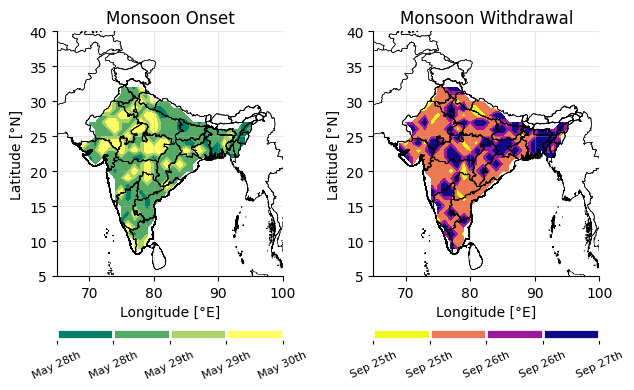

In [5]:
# Load country boundary data
mask_boundary = gpd.read_file(world_boundary_file)
mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

result_plot = breakpoints.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
result_plot.rio.write_crs("epsg:4326", inplace=True)
result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)

# result_plot = breakpoints

fig, ax, cbars = plot_seasons_bk_results(  result_plot,
                                    nrows = 1,
                                    ncolumns = 2,
                                    figsize=(7,7),
                                    cmaps=['summer', 'plasma_r', 'jet', 'viridis'],
                                    #  lims=[[150,180],[245,300]],
                                    nlevs=5,
                                    titles=['Monsoon Onset', 'Monsoon Withdrawal', 'aa', 'dsd'],
                                    country_boundary=country_boundary, 
                                    world_boundary=world_boundary,
                                    xlims=[65, 100],
                                    ylims=[5, 40],
                                    wspace=0.4,  
                                    )

for j in range(n_seasons):
    cbars[j].ax.tick_params(labelsize=8, rotation=25)

# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [6]:
if not os.path.exists(results_path_file) or overwrite_results:
    
    breakpoints.attrs=dict(
            Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
            Parameters=(

                f"Number of seasons: {n_seasons}",
                f"Number of iterations: {n_iters}",
                f"Learning rate: {learning_rate}",
                f"Minimum length of seasons: {min_len}",
                f"Clustering mode: {mode}",
                f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
            )
        )

    breakpoints.to_netcdf(results_path_file)

NameError: name 'day_of_year_to_date' is not defined